# 0. Load parameters


In [8]:
# | tags: [parameters]
subject = "103"

In [6]:
# | tags: [parameters]
# Injected Parameters
subject = 151

In [12]:
from pathlib import Path
from spectral.utils import print_date_time, read_parameters


print_date_time()
config = read_parameters()
project_path = config.get("paths", "PROJECT_PATH")
figures_path = config.get("paths", "FIGURES_PATH").format(
    project_path=project_path, subject=subject
)
raw_preproc_path = config.get("paths", "RAW_PREPROC_PATH").format(
    project_path=project_path, subject=subject
)
epoch_preproc_path = config.get("paths", "EPOCHS_PREPROC_PATH").format(
    project_path=project_path, subject=subject
)


Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)
Path(figures_path).mkdir(parents=True, exist_ok=True)

2024-03-22 01:27:13


In [10]:
import mne
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA
import toml
import mne_bids
import re
from pathlib import Path
import matplotlib
import numpy as np
from ipywidgets import interact
from mne.preprocessing import ICA

from eeglabio.utils import export_mne_raw

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

Using matplotlib as 2D backend.


This file contains preprocessing files after downsampling them.


# 2. Work with epochs


In [5]:
# non-filterd epochs ICAs
from mne_icalabel import label_components
from autoreject import get_rejection_threshold  # noqa


import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters

In [6]:
def compute_ica(
    eeg_data,
    reject_log=None,
    n_components=0.999,
    method="picard",
    random_state=99,
):
    """Compute ICA on the data without really bad epochs"""
    ica = ICA(
        n_components=n_components,
        random_state=random_state,
        method="picard",
        fit_params=dict(ortho=False, extended=True),
    )
    ica.fit(eeg_data)

    return ica


def label_components_ica(eeg_data, ica):
    """Assign the IC labels"""

    ic_labels = label_components(eeg_data, ica, method="iclabel")
    labels = ic_labels["labels"]
    return labels, ic_labels


def get_values(labels, ic_labels, threshold=0.8):
    """Get the indices of the labels"""
    element_indices = {}
    element_indices["bad_prob_class"] = []
    prababilities = ic_labels["y_pred_proba"]

    for i, element in enumerate(labels):
        if prababilities[i] > 0.8:
            if element not in element_indices:
                element_indices[element] = []
            element_indices[element].append(i)
        else:
            element_indices["bad_prob_class"].append(i)

    # display(element_indices)
    return element_indices


def plot_ica_components(ica, eeg_data, plot_properties=[]):
    """Plot the ICA components"""

    label_components_ica(eeg_data, ica)
    labeled_components = get_values(labels, ic_labels)

    for label, indices in labeled_components.items():
        # display(label, indices)
        # ica_plot = ica.plot_sources(
        #    eeg_data, show_scrollbars=False, picks=slice(0, 20))
        print(label, indices)
        ica_plot = ica.plot_components(picks=indices)

        chunk_size = 20
        chunks = [
            indices[i : i + chunk_size] for i in range(0, len(indices), chunk_size)
        ]
        for chunk in chunks:
            ica_plot = ica.plot_sources(
                eeg_data,
                show_scrollbars=False,
                picks=chunk,
                start=0,
                stop=len(epochs) - 1,
            )

        if plot_properties:
            ica.plot_properties(eeg_data, picks=indices, psd_args={"fmax": 100.0})
    return labeled_components


def plot_removed_components(
    ica,
    eeg_data,
    labeled_components,
    chosen_components=[
        "eye blink",
        "heart beat",
        "line noise",
        "muscle artifact",
        "channel noise",
    ],
):
    exclude = []
    for label, indices in labeled_components.items():
        if label in chosen_components:
            ica_plot = ica.plot_sources(eeg_data, show_scrollbars=False, picks=indices)
            display(label, indices)
            figs = ica.plot_properties(epochs, picks=indices, psd_args={"fmax": 100.0})

            for fig, ind in zip(figs, indices):
                # fig = ica.plot_properties(eeg_data, picks=ind)
                fig.savefig(
                    f"{figure_path}/sub-{subject}_ICA{str(ind).zfill(3)}_{
                        label.replace(" ", "-")}.png",
                    dpi=300,
                    bbox_inches="tight",
                )
            exclude = exclude + indices
    return exclude

In [7]:
epochs = mne.read_epochs(
    f"{epochs_path}/sub-{subject}_drop_bad-epo.fif", preload=True)
ica = compute_ica(epochs, n_components=0.99, method="picard")
labels, ic_labels = label_components_ica(epochs, ica)

Reading /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-151/epochs/sub-151_drop_bad-epo.fif ...


    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA to data using 248 channels (please be patient, this may take a while)
Selecting by explained variance: 47 components
Fitting ICA took 19.5s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_93331/3781724581.py:23: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(eeg_data, ica, method="iclabel")


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_93331/3781724581.py:23: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(eeg_data, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
bad_prob_class [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 23, 24, 26, 28, 29, 32, 33, 34, 35, 36, 39, 41, 42, 44, 45]


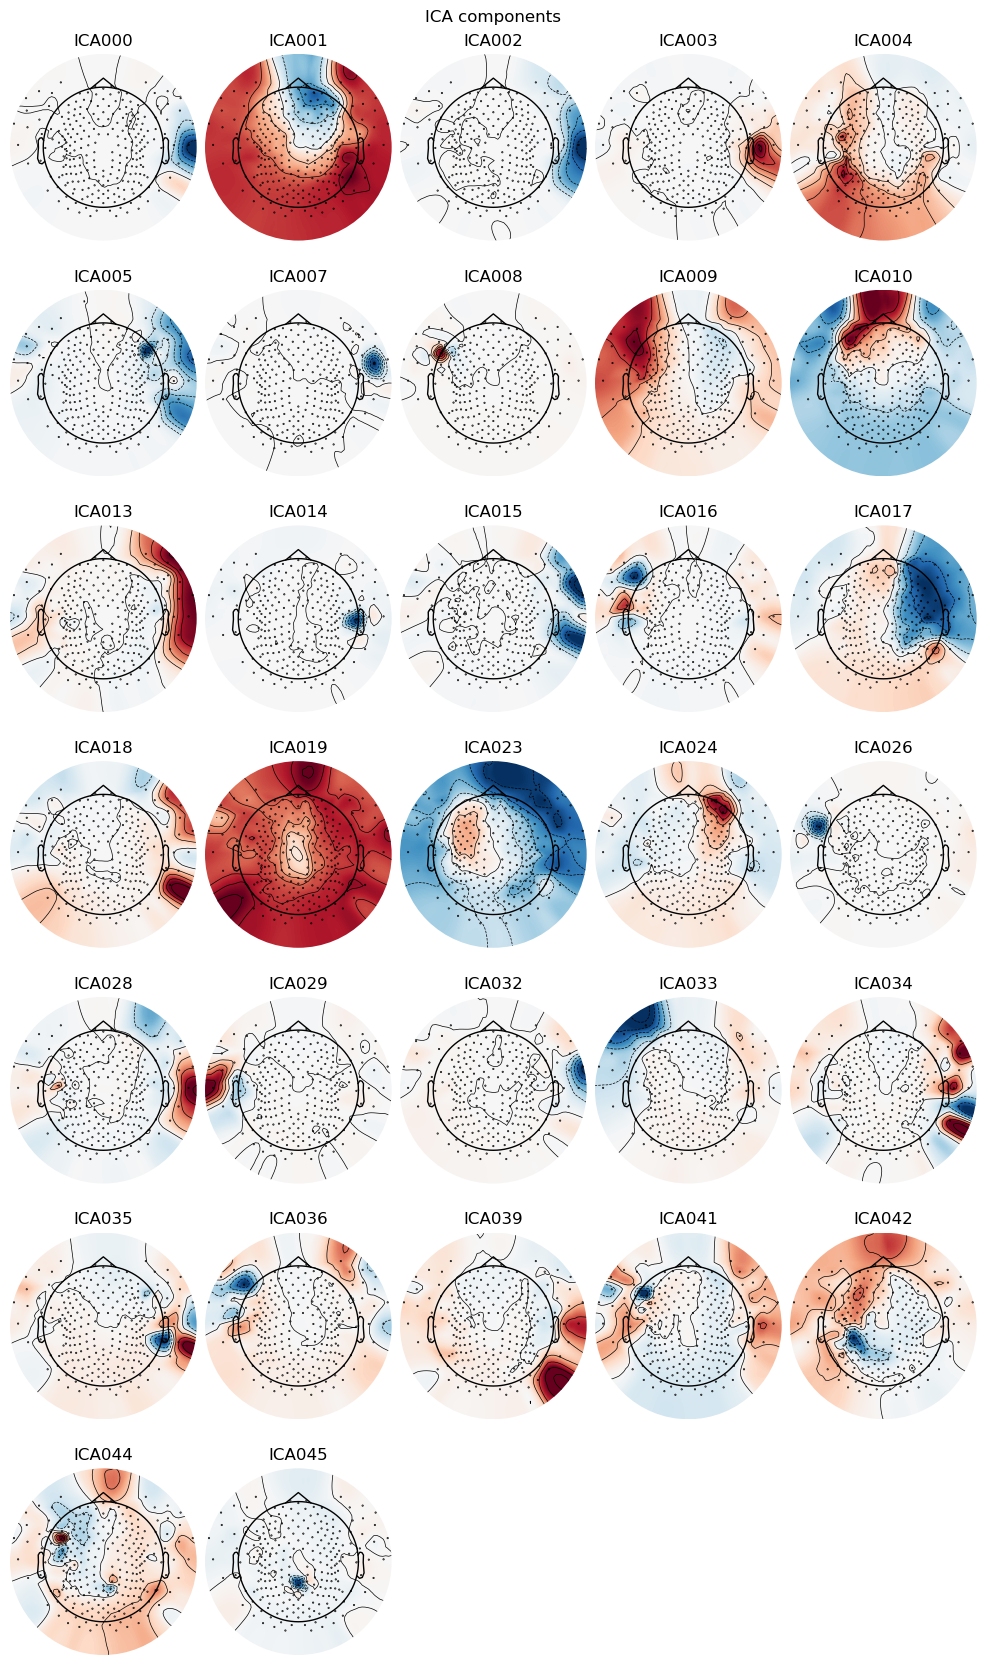

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


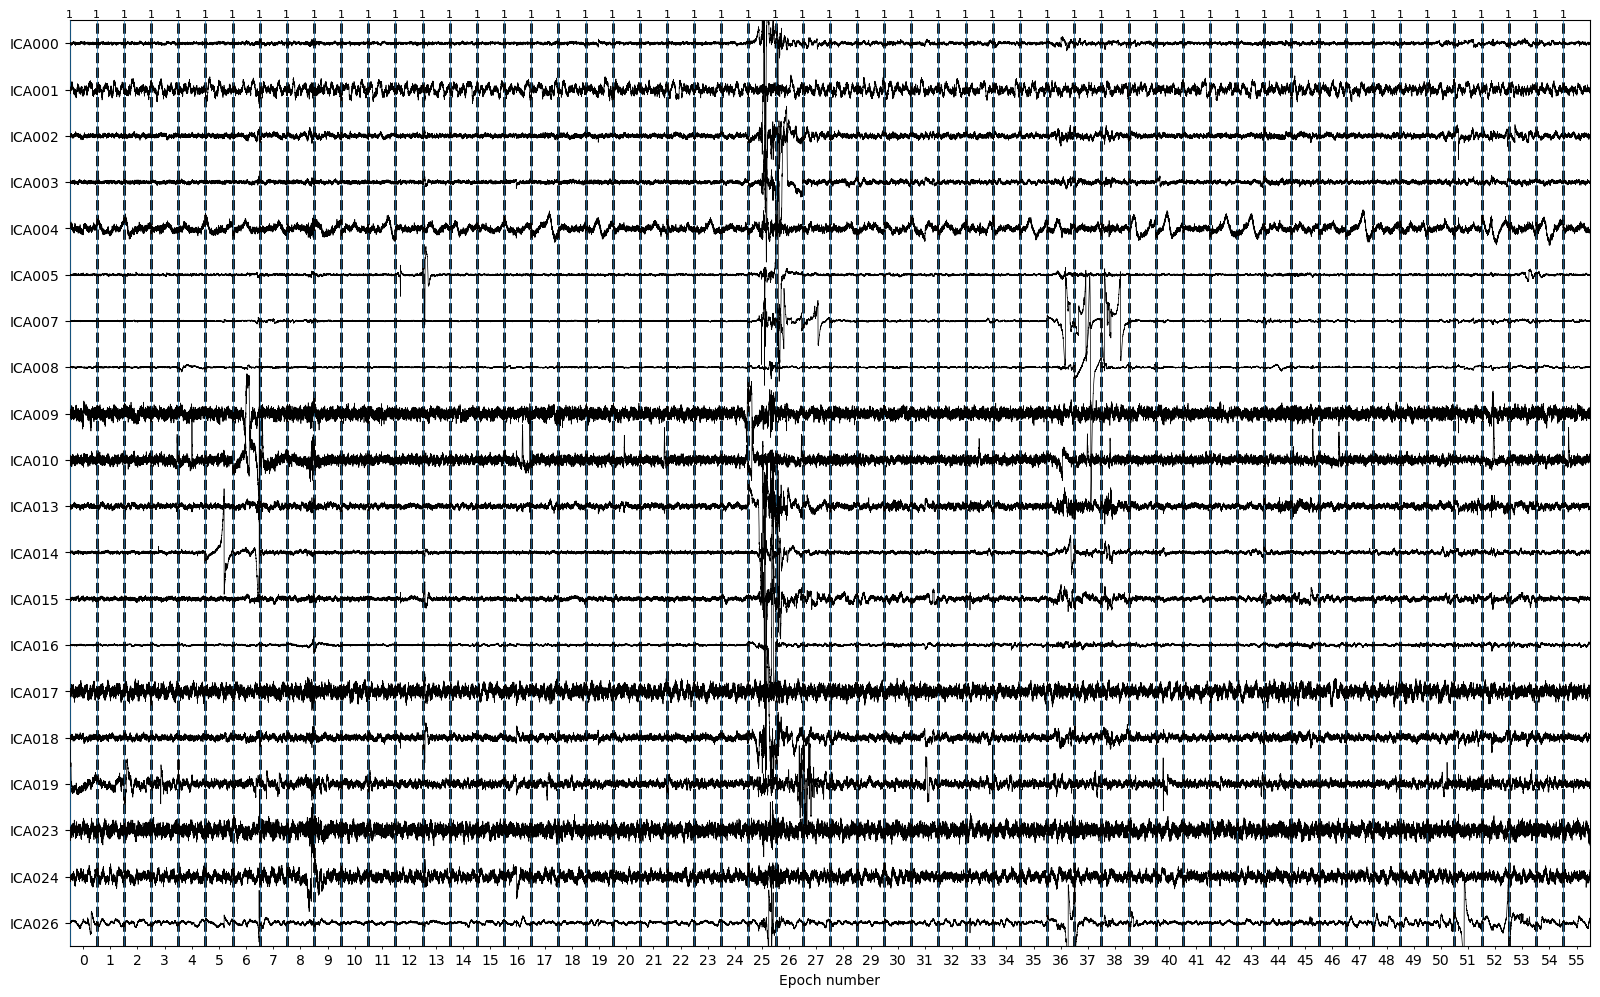

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


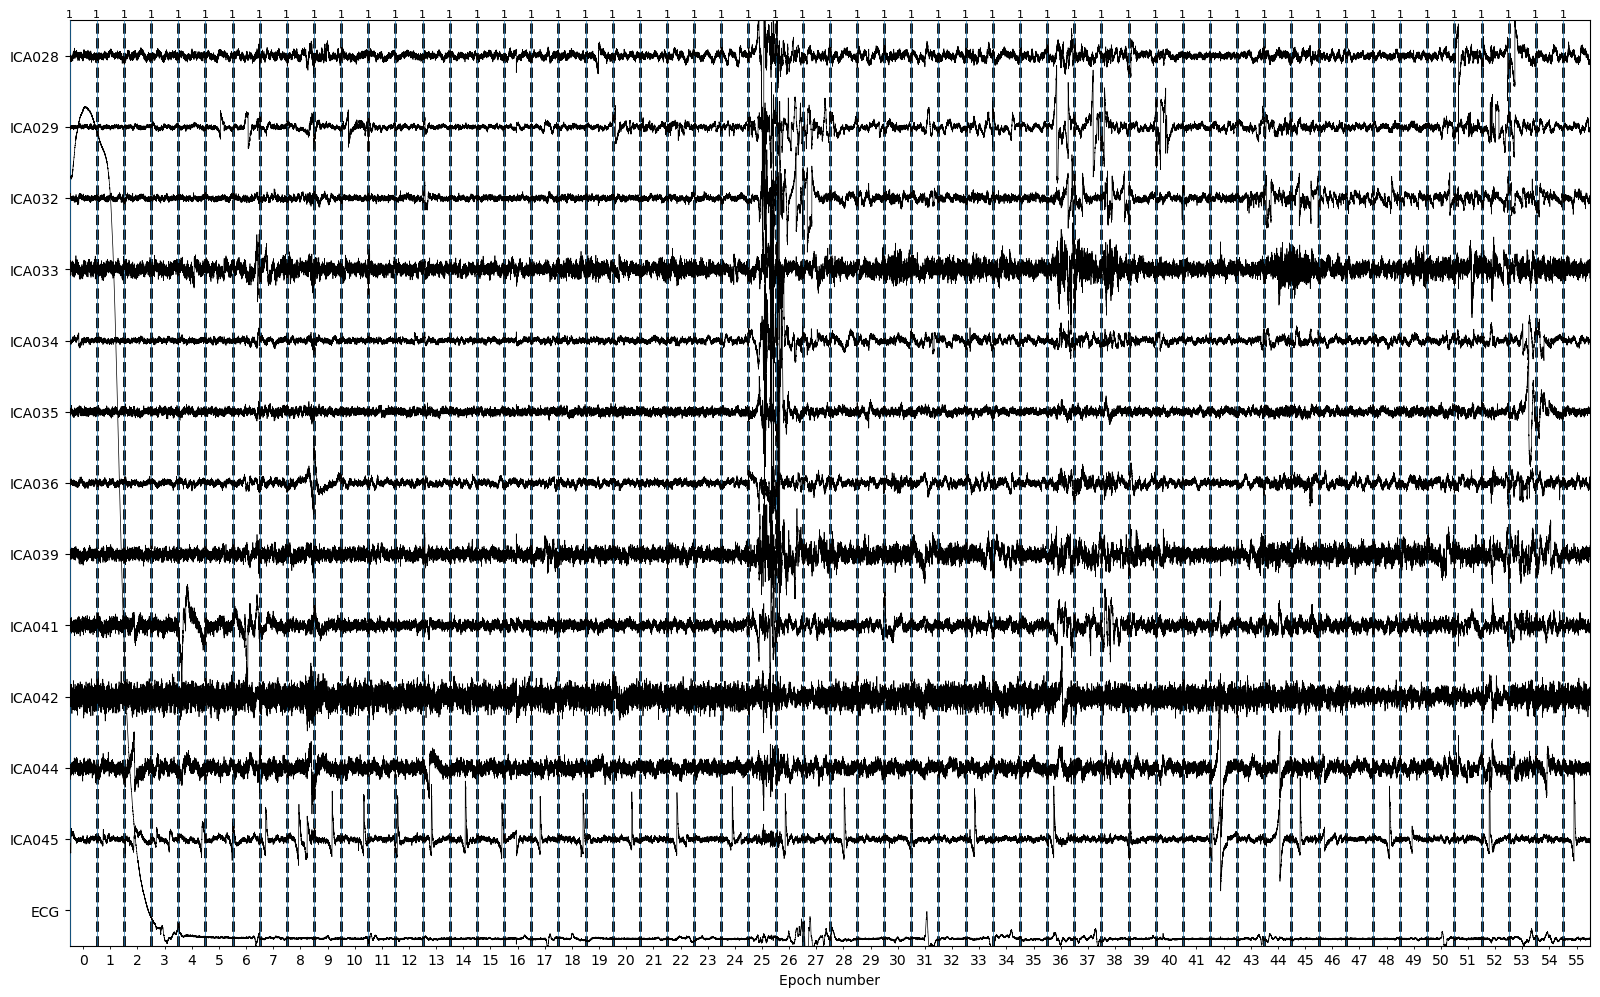

brain [6, 20, 21, 25]


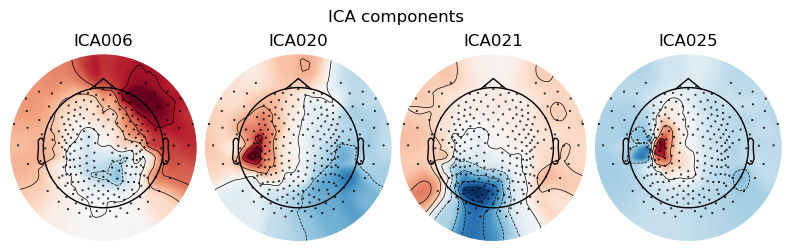

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


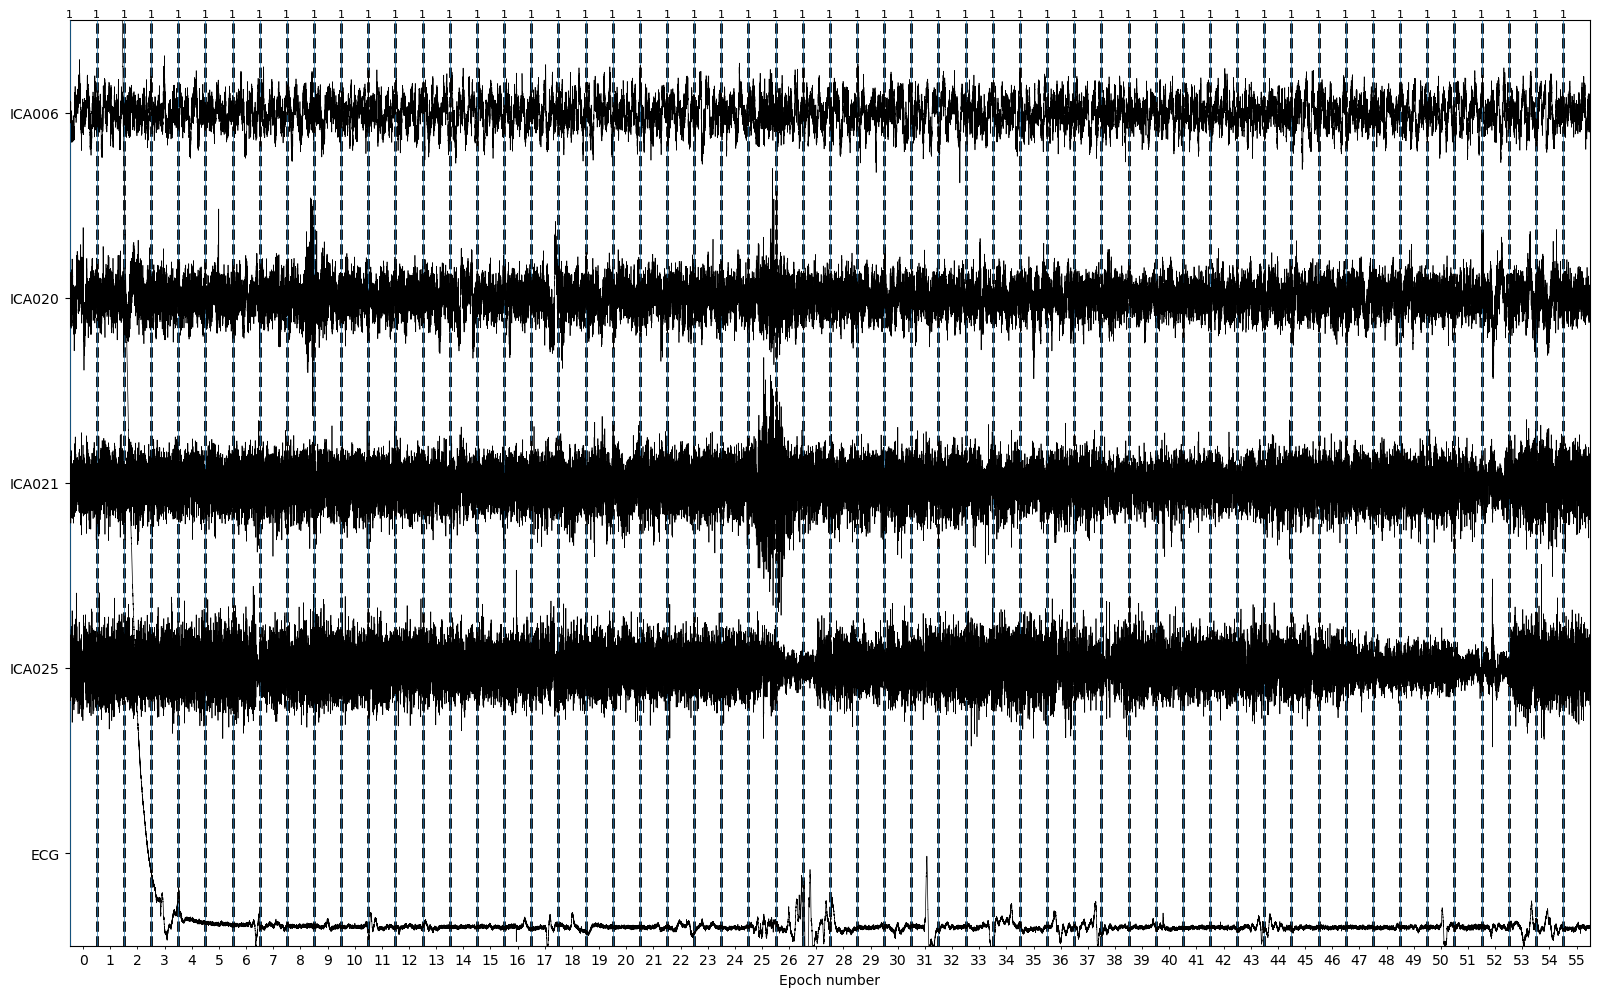

channel noise [11, 43, 46]


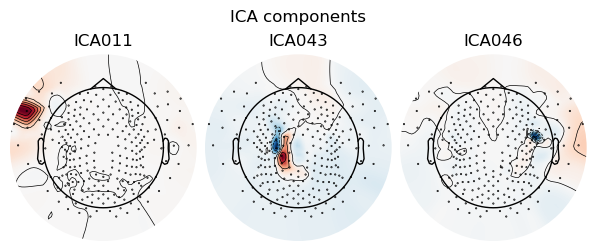

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


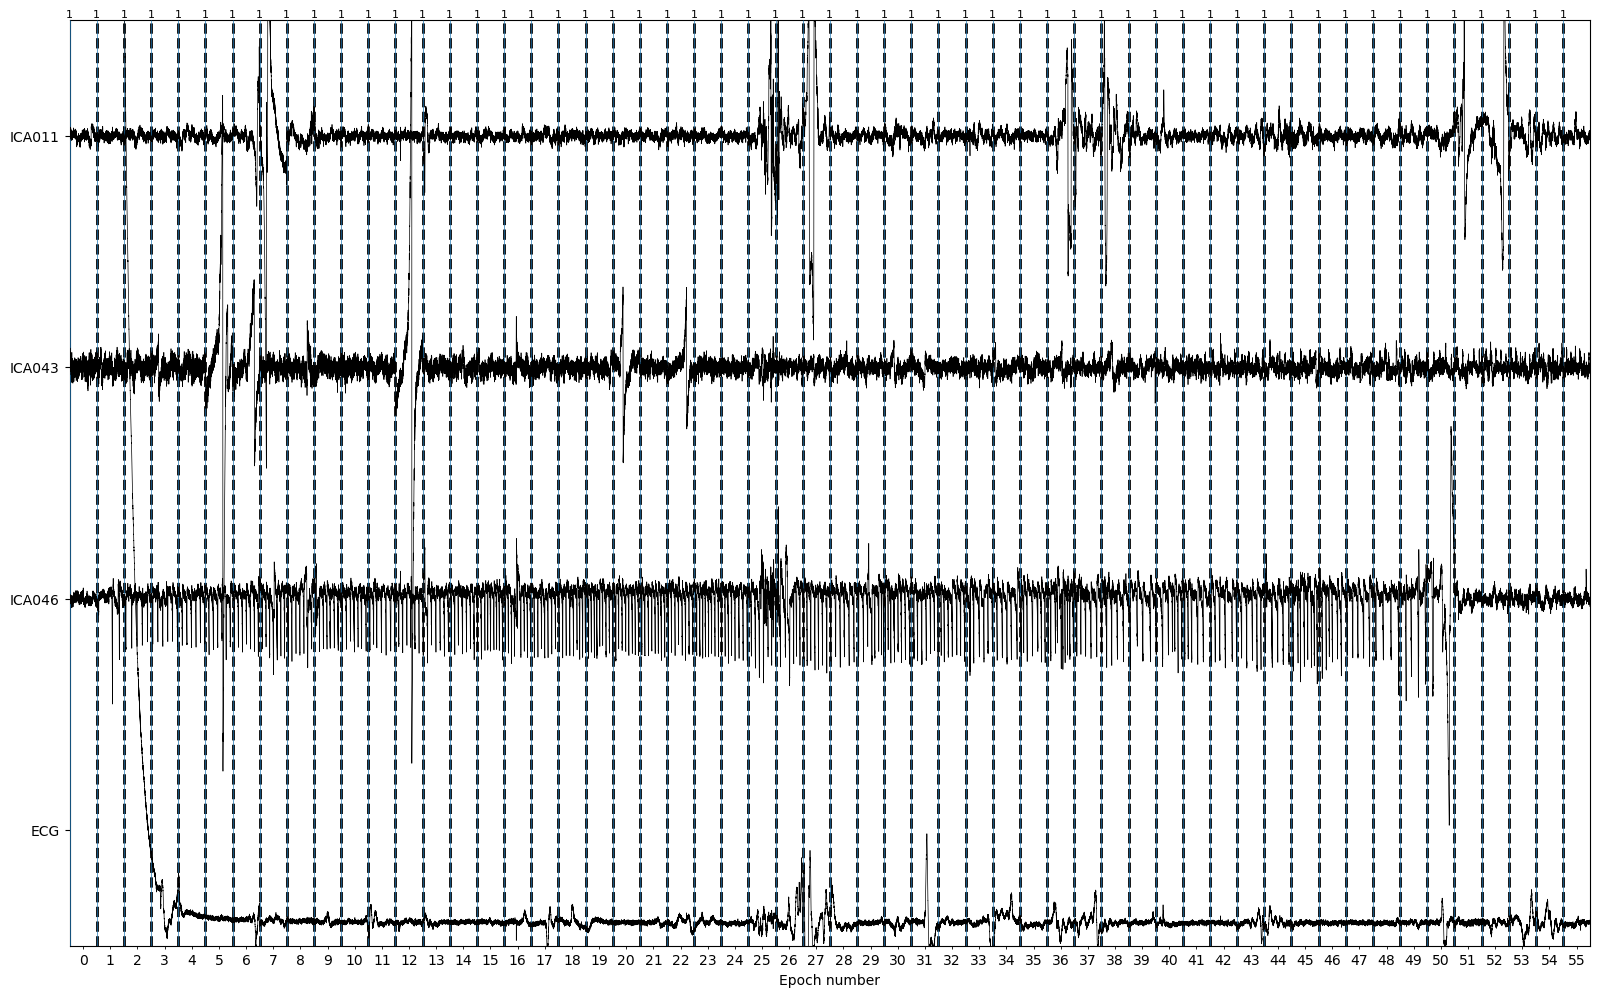

muscle artifact [12, 30, 40]


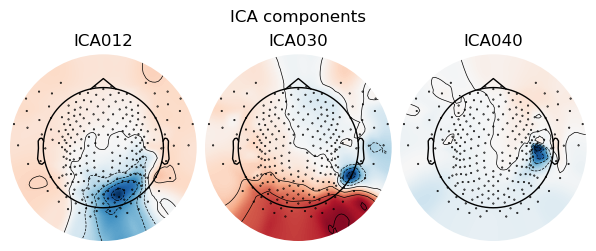

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


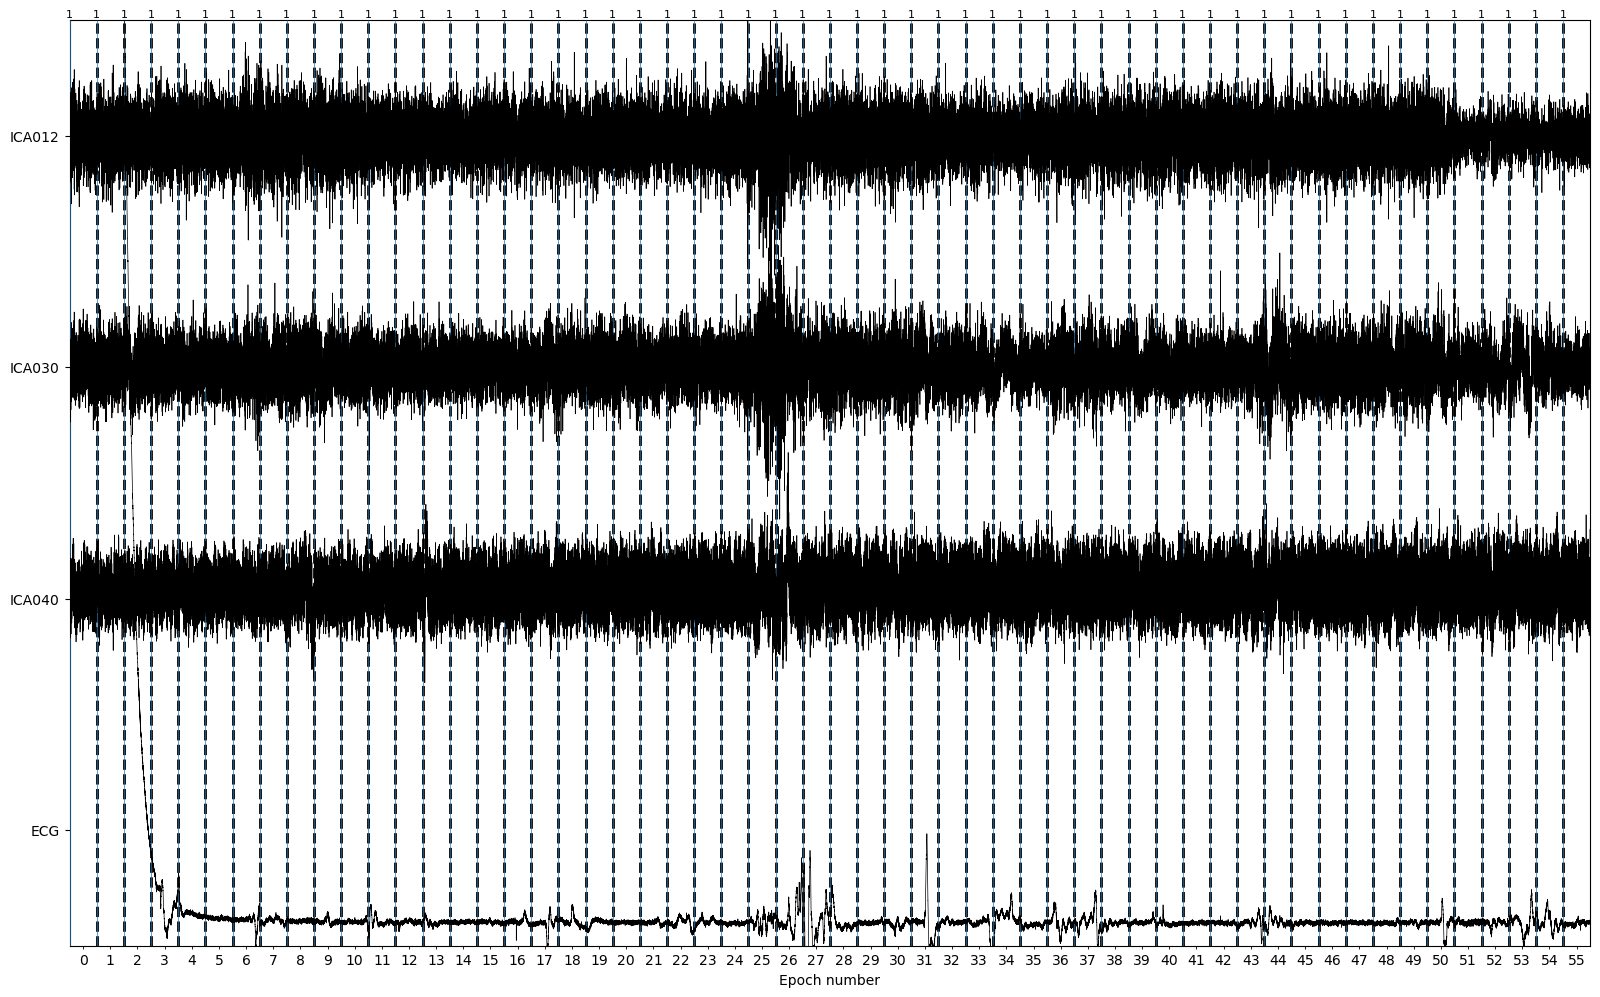

other [22, 27, 31, 37, 38]


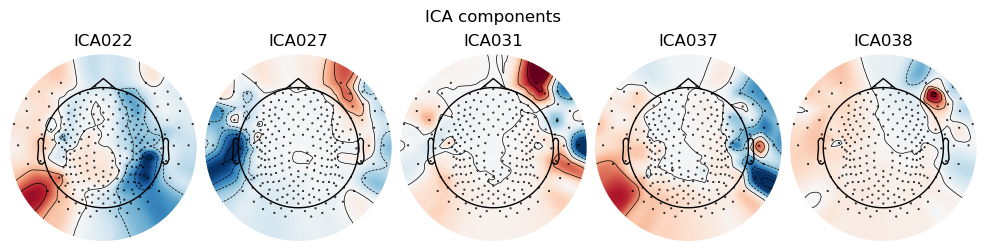

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


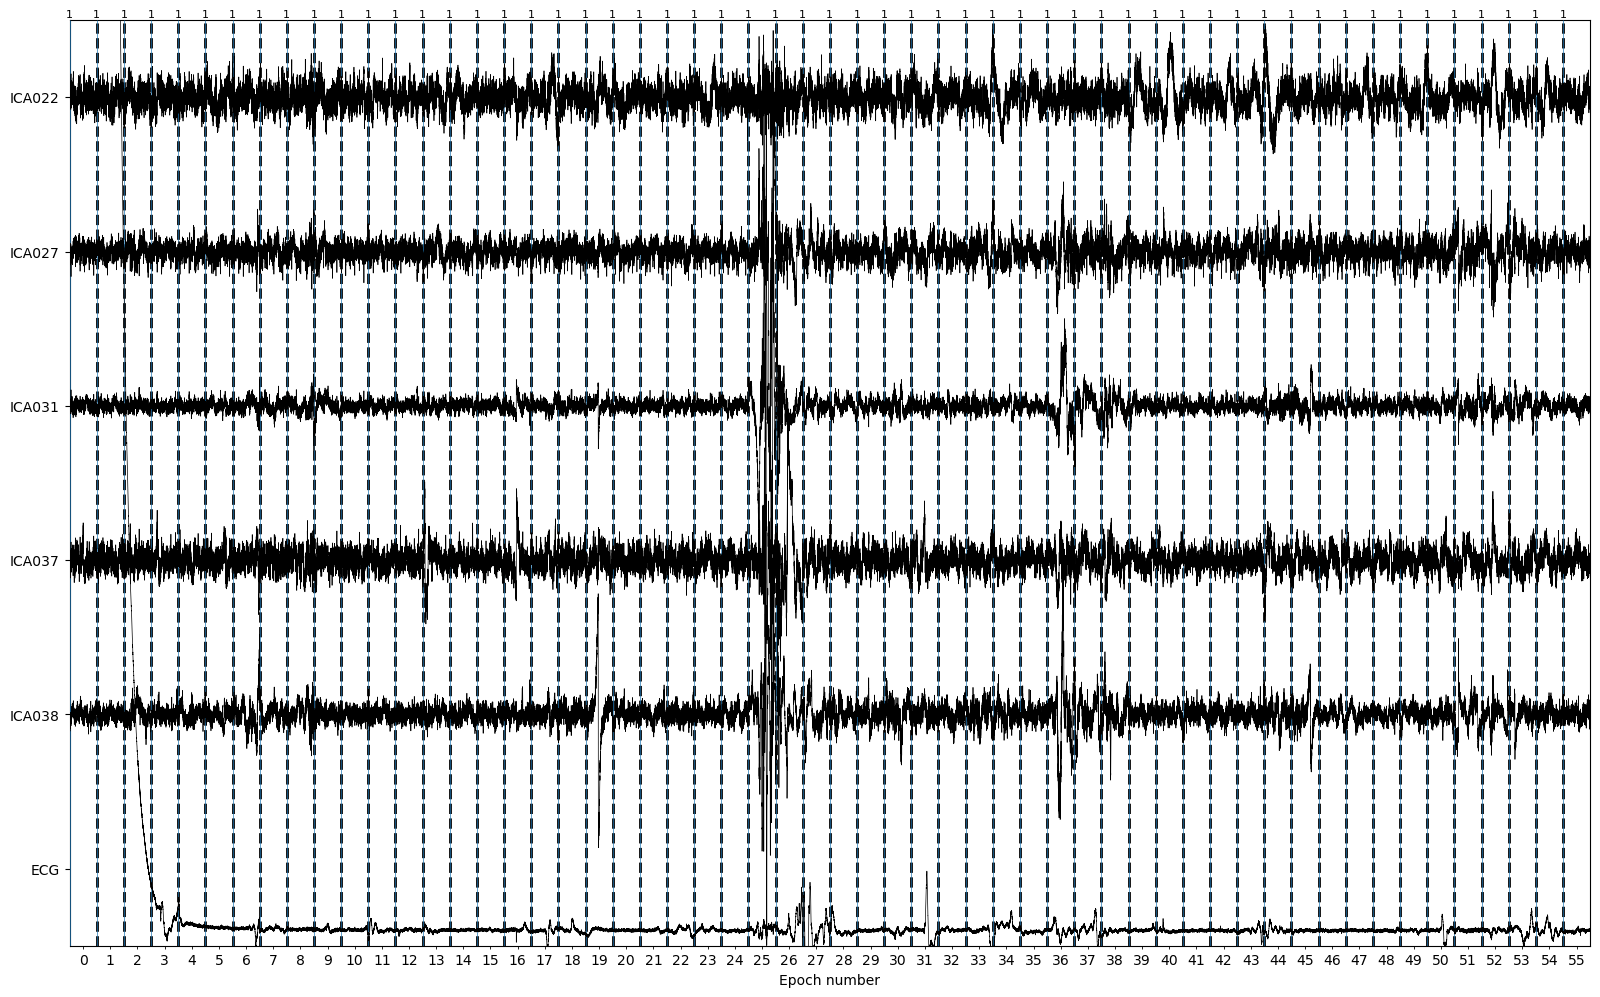

In [8]:
labeled_components = plot_ica_components(ica, epochs, plot_properties=False)

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


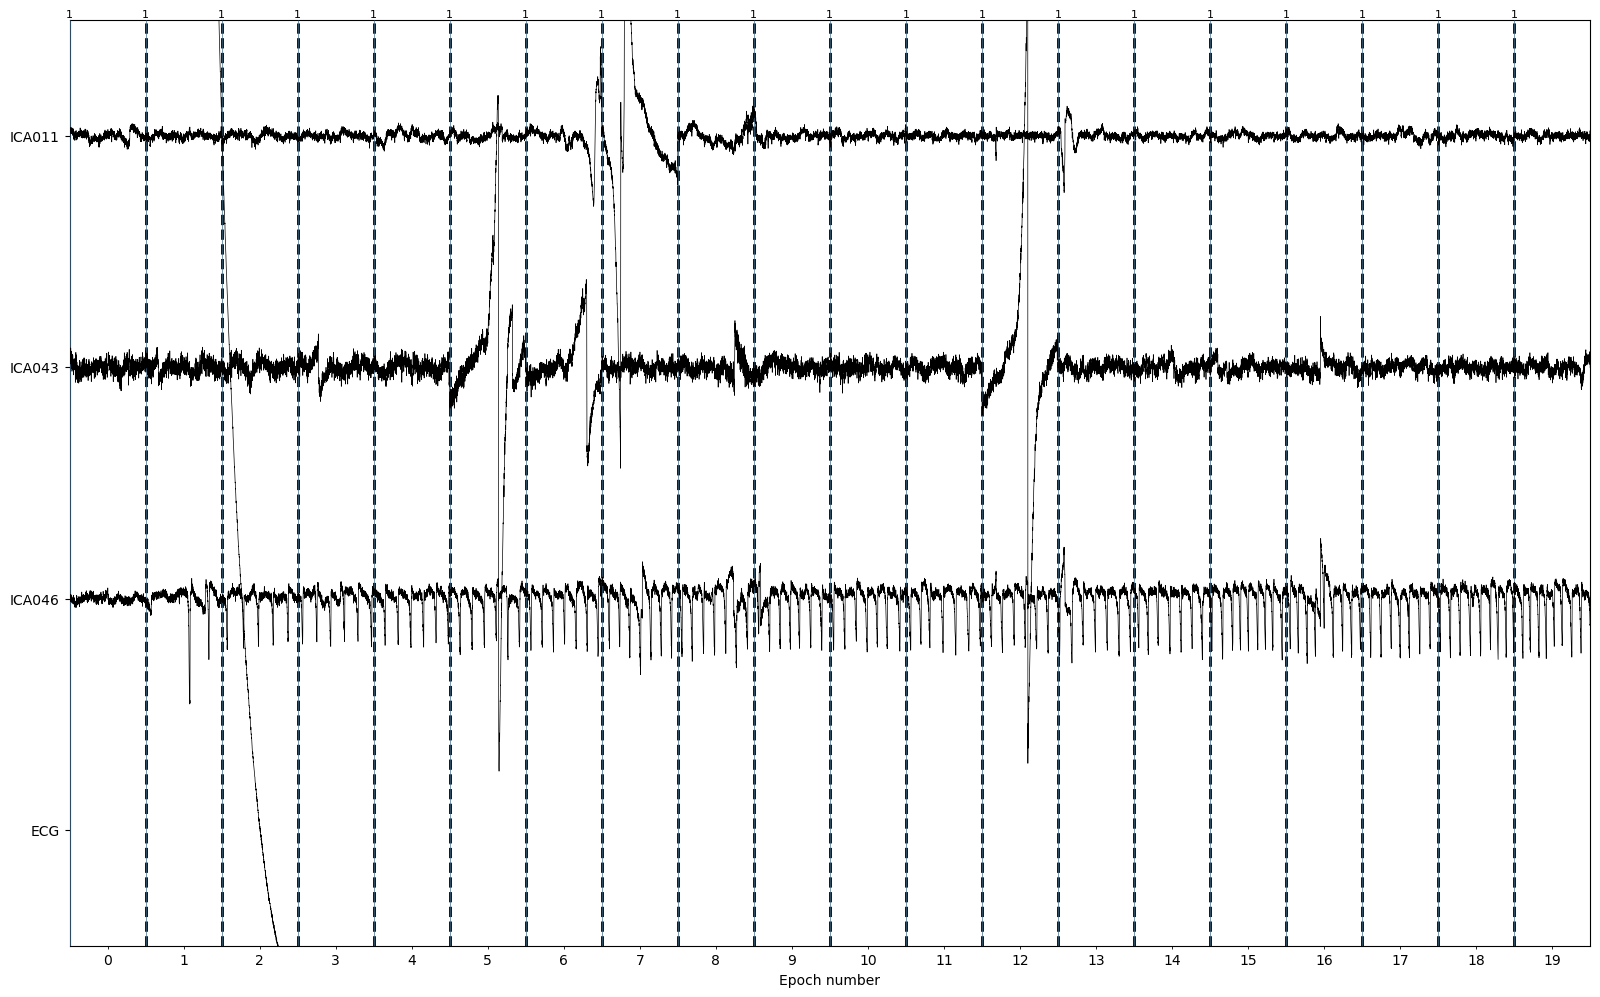

'channel noise'

[11, 43, 46]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


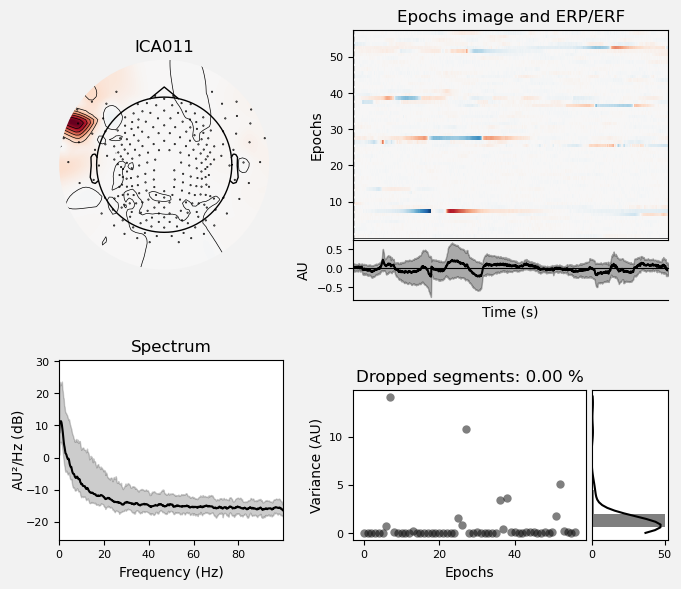

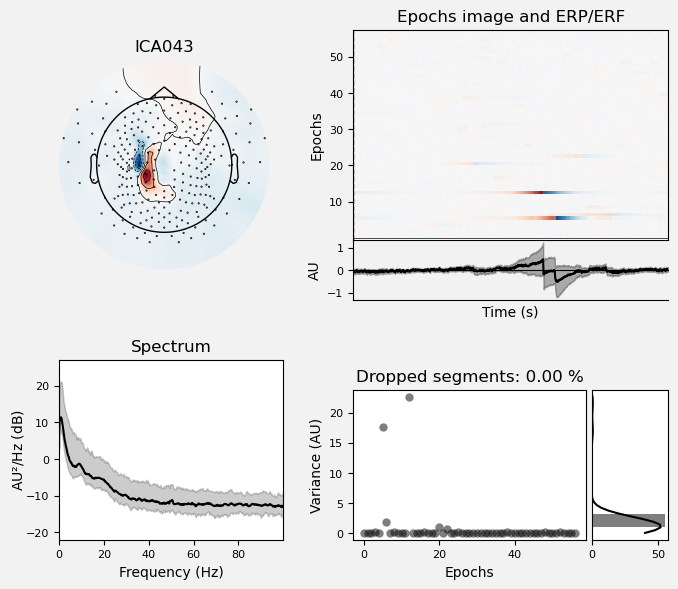

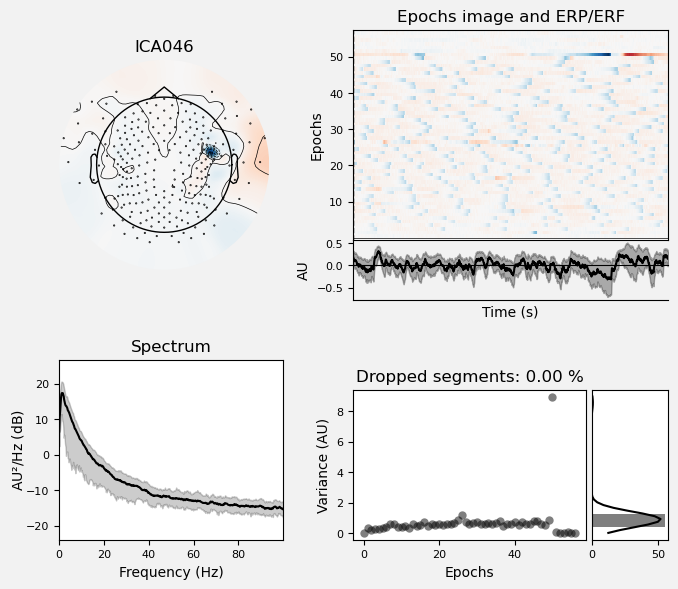

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


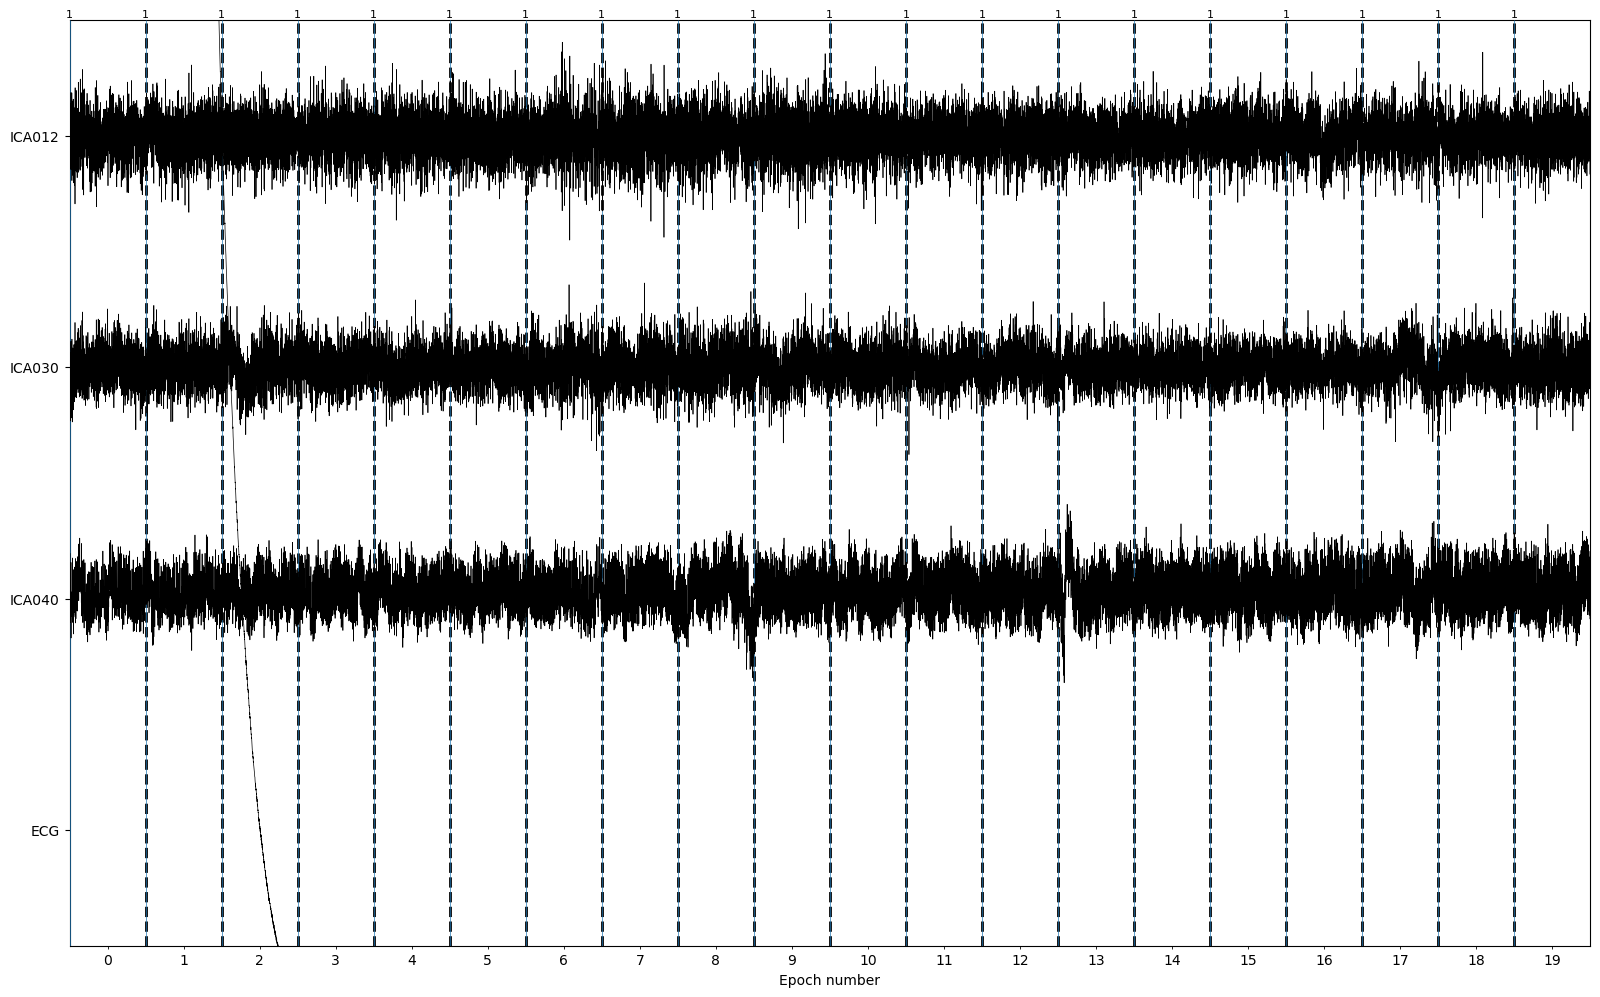

'muscle artifact'

[12, 30, 40]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


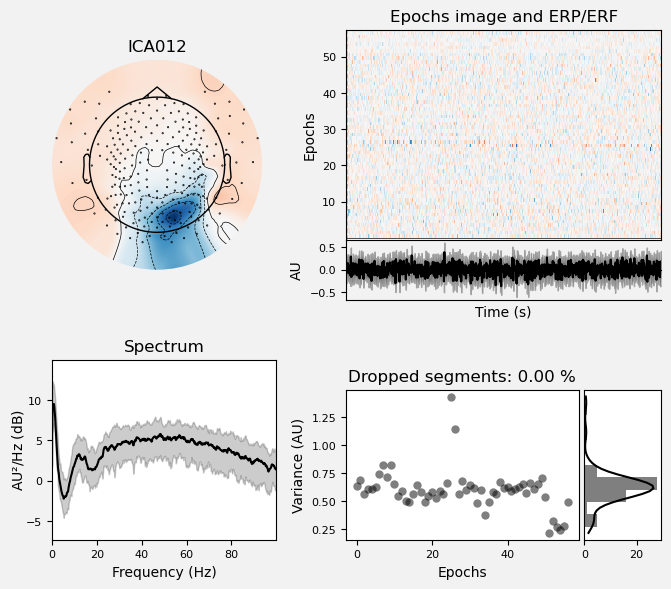

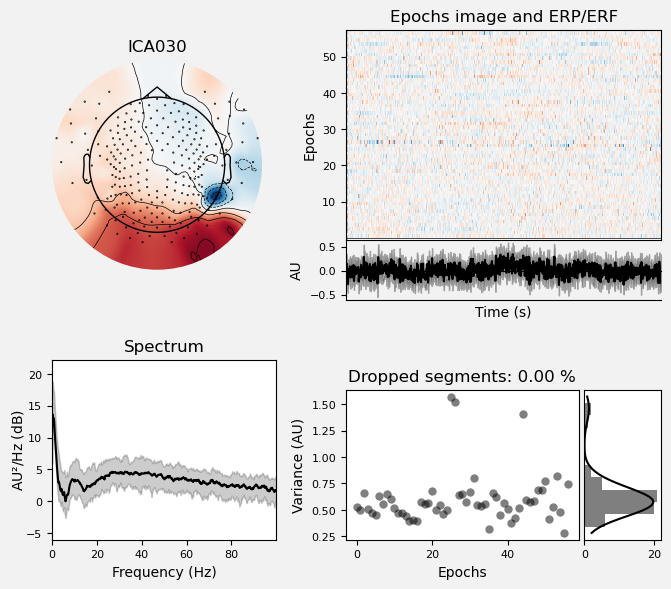

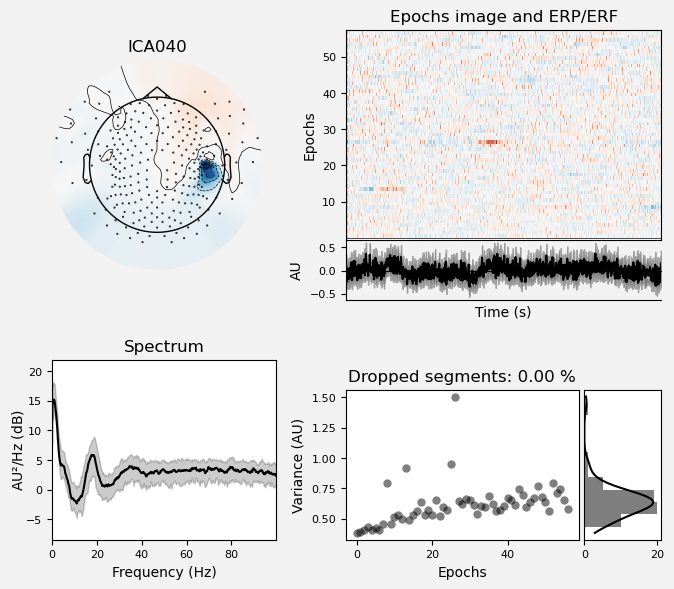

In [9]:
chosen_components = [
    "eye blink",
    "heart beat",
    "line noise",
    "muscle artifact",
    "channel noise",
]
exclude = plot_removed_components(
    ica, epochs, labeled_components, chosen_components=chosen_components
)

Opening raw data file /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-151/raw//sub-151_filtered_zap_eeg.fif...
    Range : 0 ... 147499 =      0.000 ...   294.998 secs
Ready.
Reading 0 ... 147499  =      0.000 ...   294.998 secs...
... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated


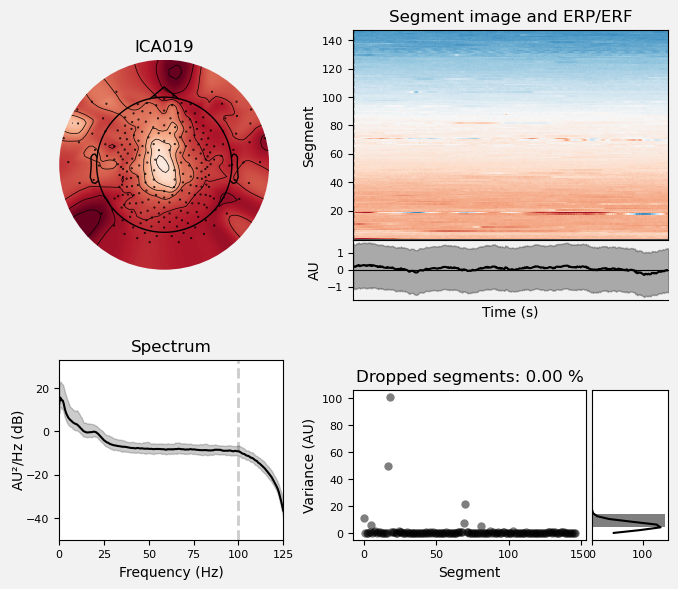

Creating RawArray with float64 data, n_channels=2, n_times=147500
    Range : 0 ... 147499 =      0.000 ...   294.998 secs
Ready.


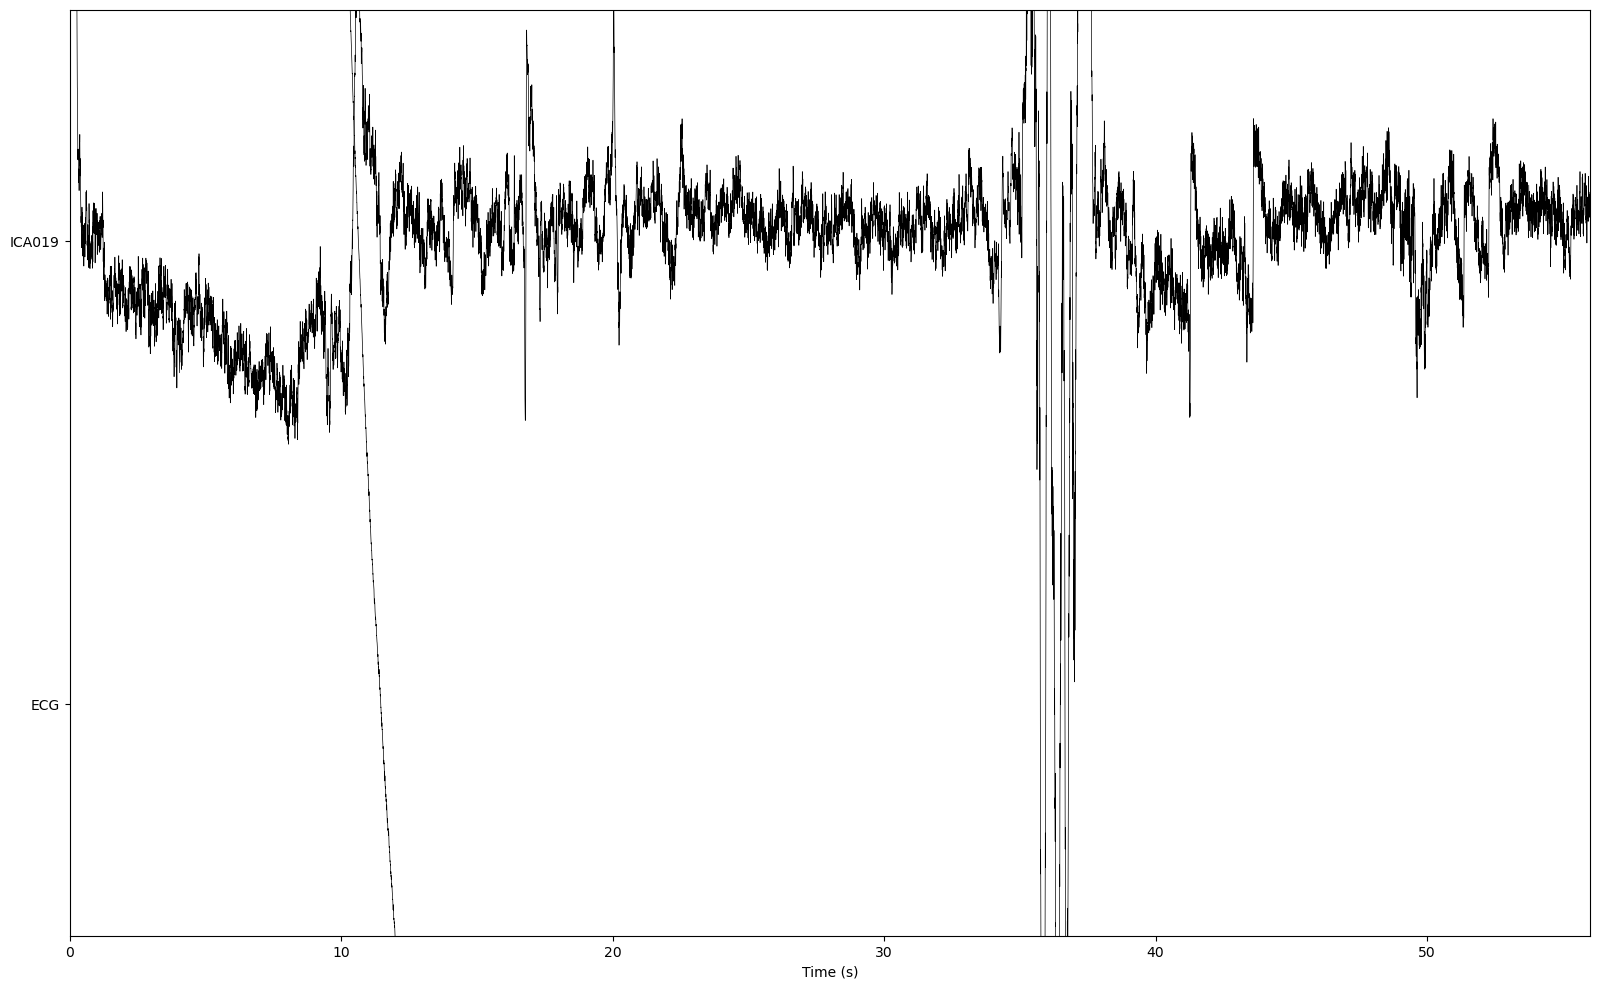

In [10]:
# ica_plot = ica.plot_sources(eeg_data)
# Exclude blink artifact components (use Fp1 as EOG proxy)
clean_raw = mne.io.read_raw_fif(
    f"{preproc_path}/sub-{subject}_filtered_zap_eeg.fif", preload=True
)
# epochs_eog = mne.preprocessing.create_eog_epochs(raw=clean_raw, ch_name="EOG")
# eog_indices, eog_scores = ica.find_bads_eog(epochs_eog, ch_name="E31", threshold=2)
ecg_indices, ecg_scores = ica.find_bads_ecg(
    clean_raw, method="correlation", threshold="auto"
)

# ica.exclude = np.argwhere(abs(eog_scores) > 0.5).ravel().tolist()

# barplot of ICA component "EOG match" scores
ica.plot_properties(clean_raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ecg_plot = ica.plot_sources(
    clean_raw,
    show_scrollbars=False,
    picks=ecg_indices,
    start=0,
    stop=len(epochs) - 1,
)

# Automated exclusion of ICA components


Applying ICA to Epochs instance
    Transforming to ICA space (47 components)
    Zeroing out 7 ICA components
    Projecting back using 248 PCA components
Overwriting existing file.
Overwriting existing file.


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_93331/578060083.py:3: RuntimeWarning: This filename (/Users/daniel/PhD/Projects/psd-path/data/preproc/sub-151/epochs//sub-151_clean_ica-epo_automated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_clean.save(


No projector specified for this dataset. Please consider the method self.add_proj.


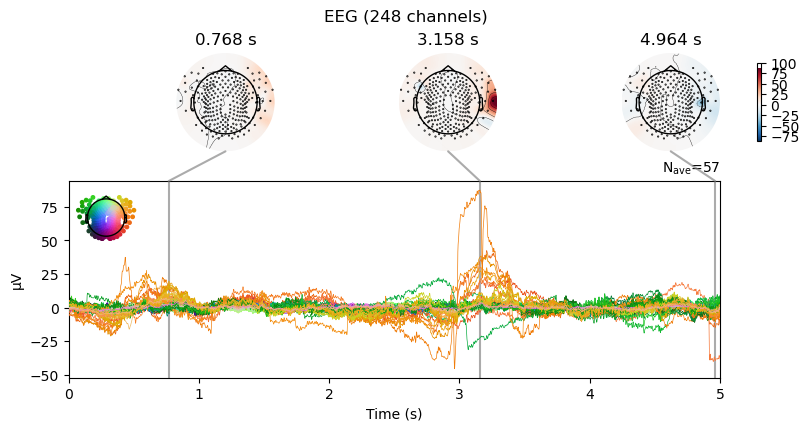

Effective window size : 4.096 (s)
Averaging across epochs...


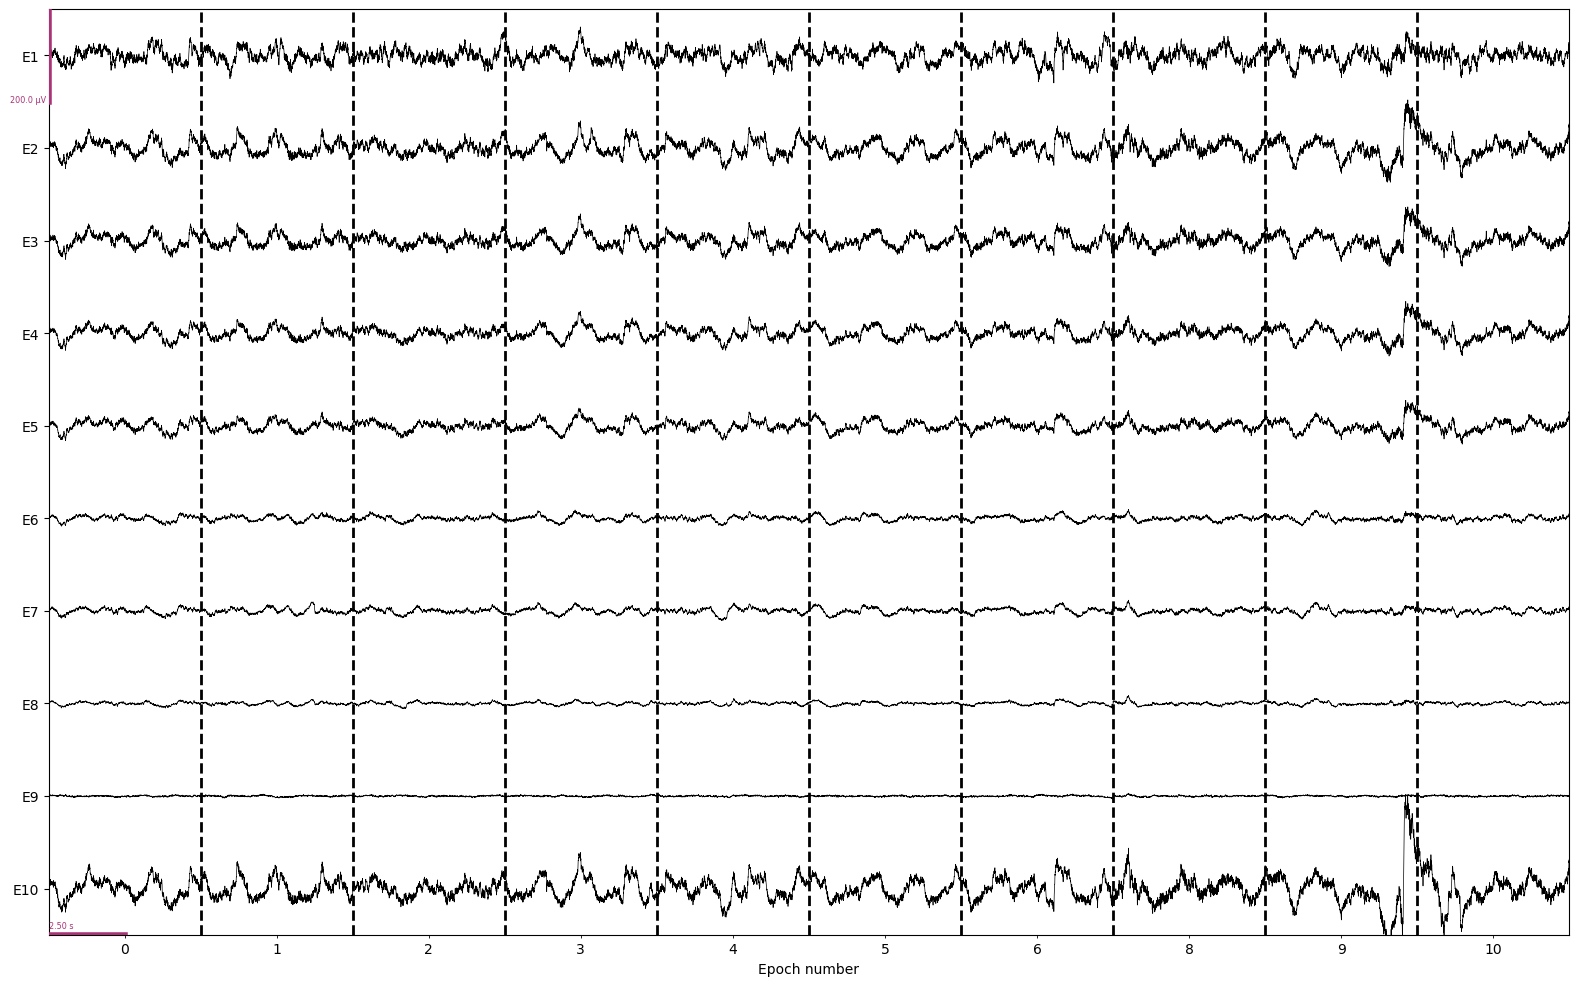

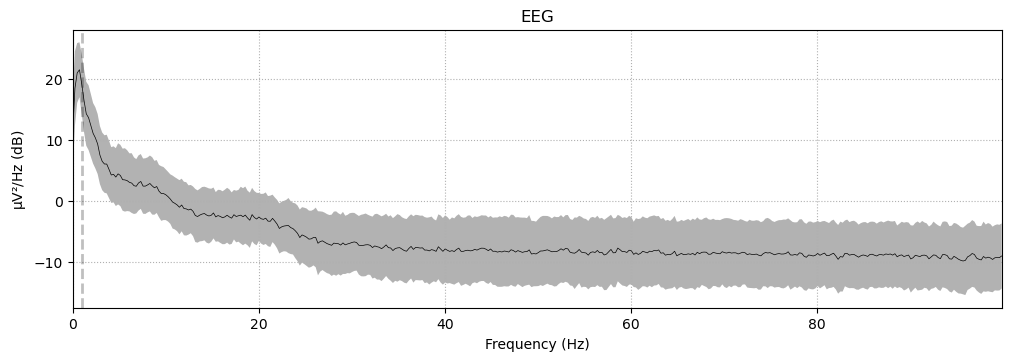

In [11]:
ica.exclude = exclude + ecg_indices
epochs_clean = ica.apply(epochs.copy(), exclude=ica.exclude)
epochs_clean.save(
    f"{epochs_path}/sub-{subject}_clean_ica-epo_automated.fif", overwrite=True
)
epochs_clean_plot = plot_epochs(epochs_clean, stage="epochs_after_ICA")

# Manually exclude more components


Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


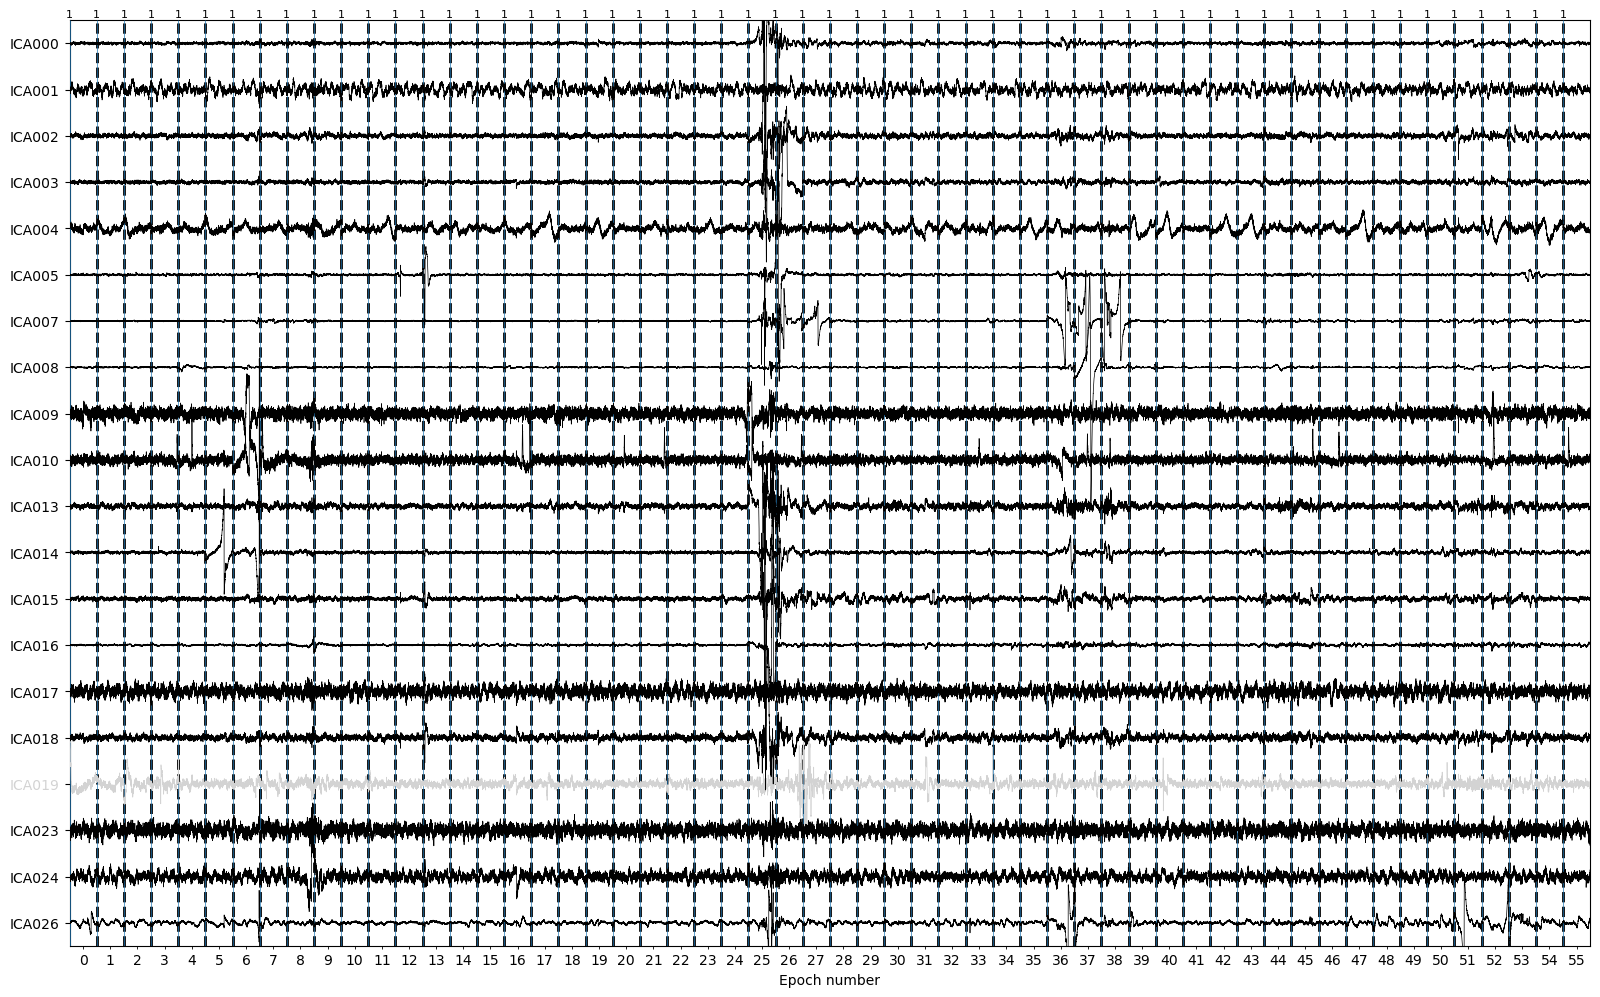

Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


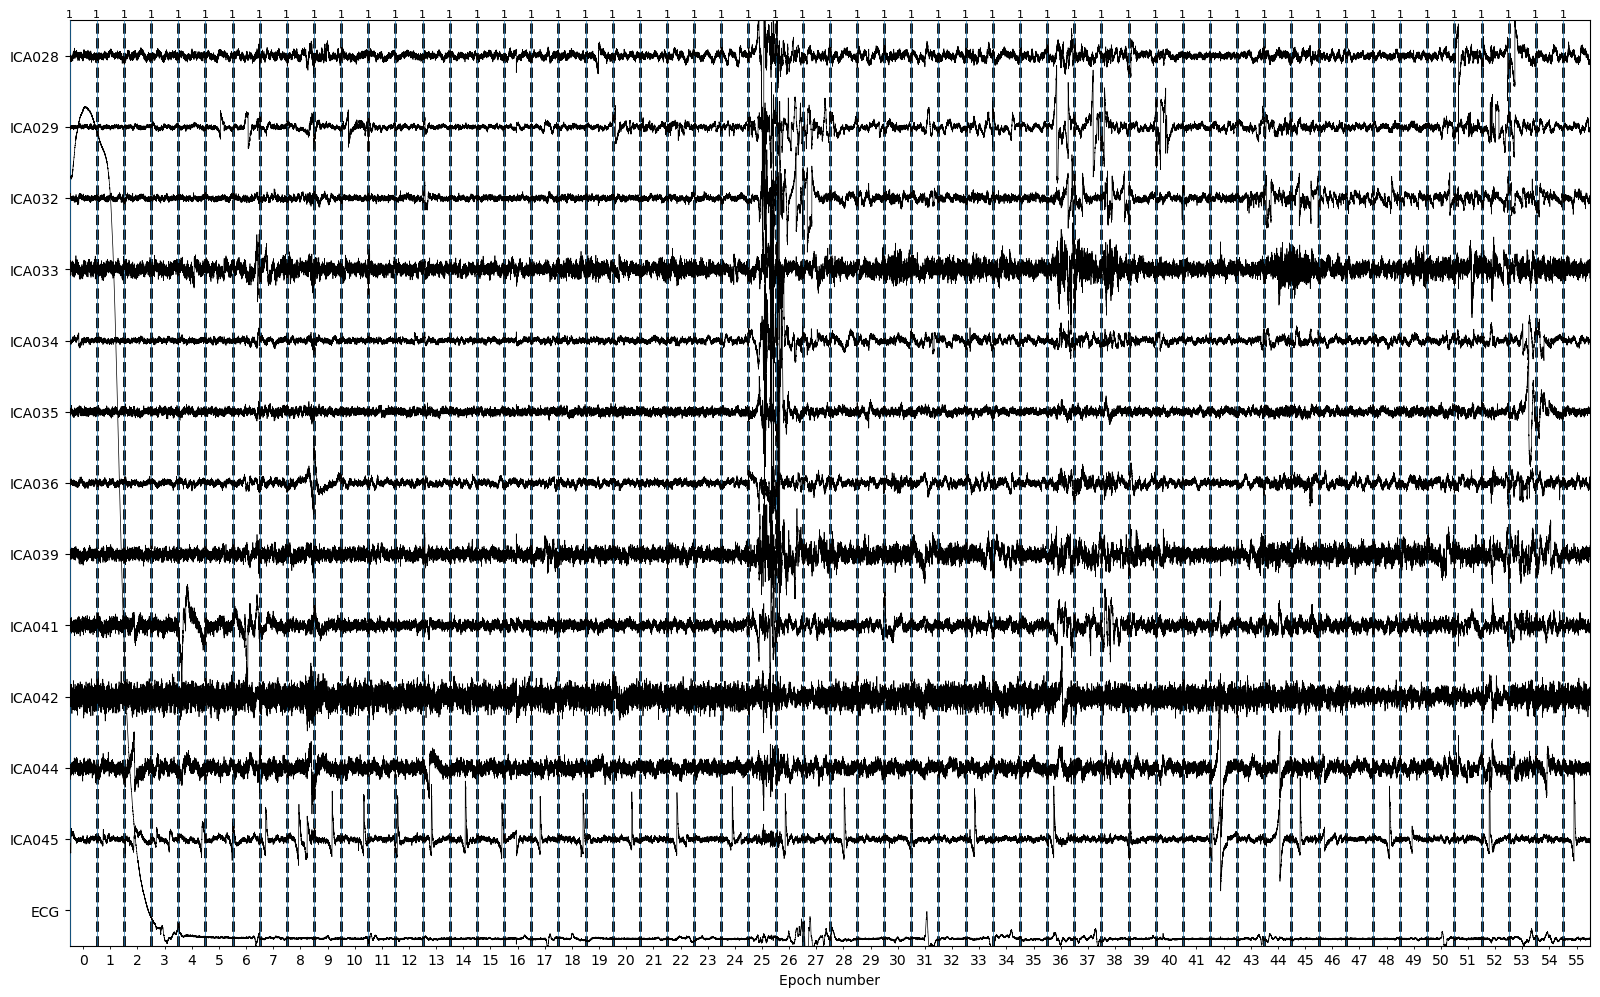

In [12]:
chunk_size = 20
indices = labeled_components["bad_prob_class"]
chunks = [indices[i : i + chunk_size] for i in range(0, len(indices), chunk_size)]
for chunk in chunks:
    ica_plot = ica.plot_sources(
        epochs,
        show_scrollbars=False,
        picks=chunk,
        start=0,
        stop=len(epochs) - 1,
    )
manual_exclude = []  # [1, 19, 36] template should not have manual excluded be used
if manual_exclude:
    figs = ica.plot_properties(epochs, picks=manual_exclude, psd_args={"fmax": 100.0})

Applying ICA to Epochs instance
    Transforming to ICA space (47 components)
    Zeroing out 7 ICA components
    Projecting back using 248 PCA components
Overwriting existing file.
Overwriting existing file.


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_93331/3814702271.py:3: RuntimeWarning: This filename (/Users/daniel/PhD/Projects/psd-path/data/preproc/sub-151/epochs//sub-151_clean_ica-manual.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_clean_manual.save(


No projector specified for this dataset. Please consider the method self.add_proj.


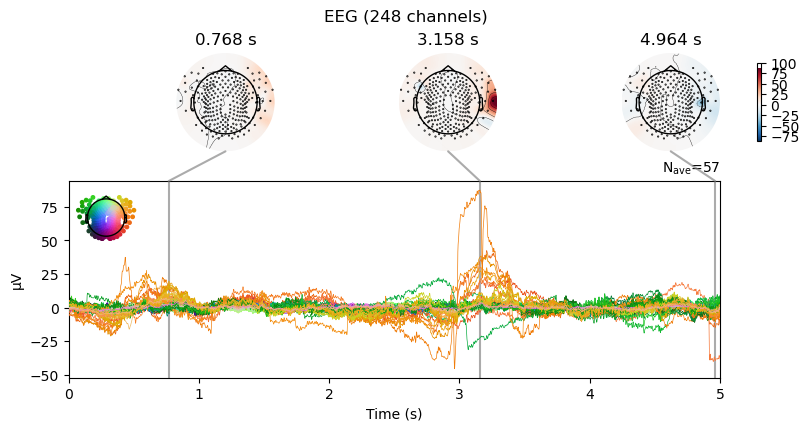

Effective window size : 4.096 (s)
Averaging across epochs...


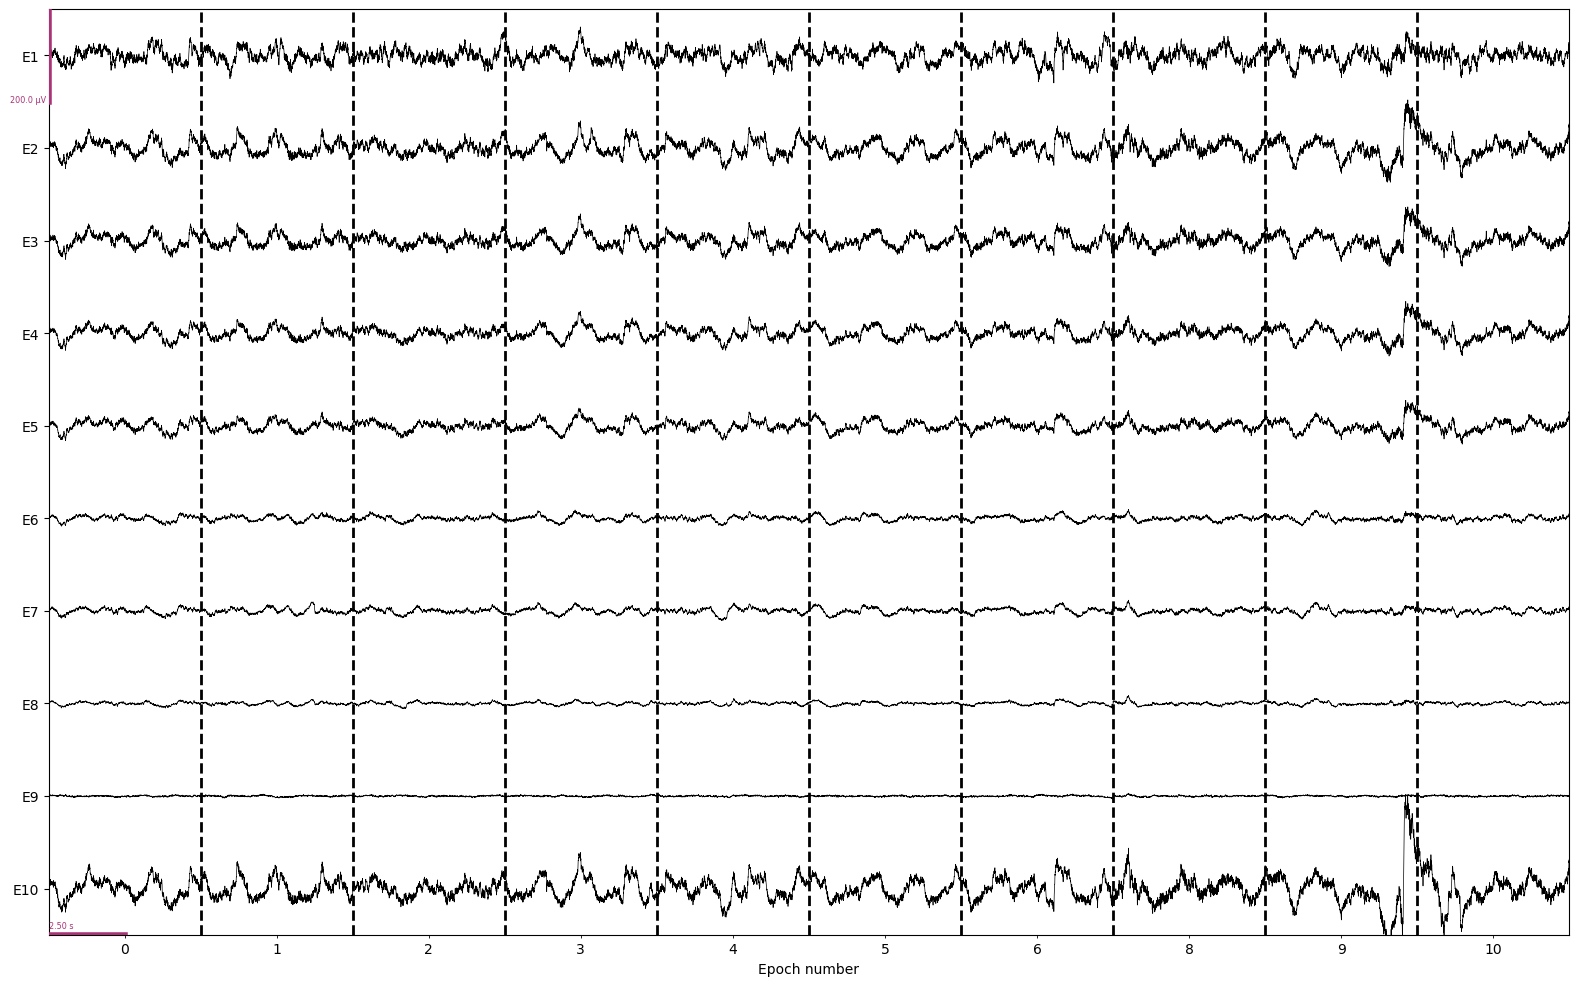

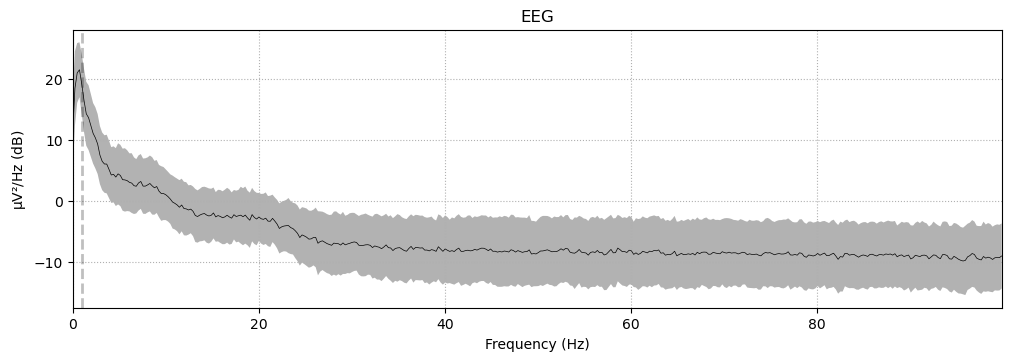

In [13]:
ica.exclude = exclude + ecg_indices + manual_exclude
epochs_clean_manual = ica.apply(epochs.copy(), exclude=ica.exclude)
epochs_clean_manual.save(
    f"{epochs_path}/sub-{subject}_clean_ica-manual.fif", overwrite=True
)
epochs_clean_plot = plot_epochs(epochs_clean, stage="epochs_after_ICA_manual")

In [15]:
print(f"There was {len(ica.exclude)} ICA components excluded: ", ica.exclude)

There was 7 ICA components excluded:  [11, 43, 46, 12, 30, 40, 19]


In [14]:
# reject_log_plot = reject_log.plot_epochs(epochs[reject_log.bad_epochs], scalings=dict(eeg=1e-4))
# with mne.viz.use_browser_backend("qt"):
#    plot_bad_epochs = epochs[reject_log.bad_epochs].plot(
#        scalings=dict(eeg=1e-4))